# Credit Risk Analytics: Predicting Loan Default using Machine Learning


In [30]:
#Step 1:Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score, f1_score
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap

warnings.filterwarnings('ignore')


In [31]:
# Step 2: Load Dataset
df = pd.read_csv(r'C:\Users\nikit\Downloads\credit_data.csv')
df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [32]:
# Step 3: Initial Exploration
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['loan_status'].value_counts(normalize=True))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

Missing Va

In [33]:
#Step 4: Feature Engineering

# Rename for clarity (optional but recommended)
df.rename(columns={'loan_percent_income': 'debt_to_income'}, inplace=True)

# Convert credit history from months to years
df['cred_hist_length_years'] = df['cb_person_cred_hist_length'] / 12

# Create income category buckets
df['income_cat'] = pd.qcut(df['person_income'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


In [34]:
#Step 5: Prepare Features and Target

target_col = 'loan_status'  # The column we want to predict (target variable)

# Separate features (X) and target (y)
X = df.drop(columns=[target_col])  # All columns except 'loan_status' become features
y = df[target_col]                  # The target variable is 'loan_status'

# Drop 'loan_percent_income' column from features if it exists
if 'loan_percent_income' in X.columns:
    X.drop('loan_percent_income', axis=1, inplace=True)
    
print("Columns in X (features):")
print(X.columns.tolist())


Columns in X (features):
['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'debt_to_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'cred_hist_length_years', 'income_cat']


In [35]:
# Step 6: Identify categorical and numeric columns
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'income_cat']
categorical_cols = [col for col in categorical_cols if col in X.columns]
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in categorical_cols]

print("Categorical:", categorical_cols)

print("Numeric:", numeric_cols)


Categorical: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'income_cat']
Numeric: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'debt_to_income', 'cb_person_cred_hist_length', 'cred_hist_length_years']


In [36]:
# Step 7: Encode target
if y.dtype == 'object' or y.dtype.name == 'category':
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y)

In [37]:
# Step 8: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



In [38]:
# Step 9: Build Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))

])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [39]:
# Step 10: Build full pipeline with SMOTE and classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'debt_to_income',
                                                   'cb_person_cred_hist_length',
                                                   'cred_hist_length_years']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file',
                                                   'income_cat'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [40]:

# Step 11: Hyperparameter Grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)


In [41]:
# Step 12: Fit model
grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_



Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [42]:
# Step 13: Predict & Evaluate on test data
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

print(f"\nROC-AUC Score: {roc_auc:.4f}")
print(f"Average Precision (PR AUC): {avg_precision:.4f}")



Confusion Matrix:
[[5013   82]
 [ 391 1031]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5095
           1       0.93      0.73      0.81      1422

    accuracy                           0.93      6517
   macro avg       0.93      0.85      0.88      6517
weighted avg       0.93      0.93      0.92      6517


ROC-AUC Score: 0.9299
Average Precision (PR AUC): 0.8793



Best Threshold for F1 Score: 0.57
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5095
           1       0.97      0.71      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.93      0.93      0.93      6517



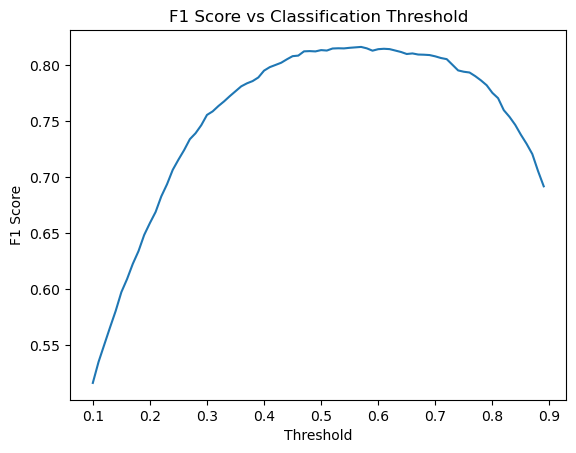

In [43]:
# Step 14: Threshold tuning by F1 score
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_prob > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold for F1 Score: {best_threshold:.2f}")

y_pred_opt = (y_prob > best_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))


plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Classification Threshold')
plt.show()



In [44]:
# Step 15: Economic Impact Analysis
cost_fp = 10000  # cost of false positive
cost_fn = 2000   # cost of false negative
cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()
total_cost = (fp * cost_fp) + (fn * cost_fn)
print(f"\nEstimated Total Economic Cost: ₹{total_cost}")



Estimated Total Economic Cost: ₹1176000


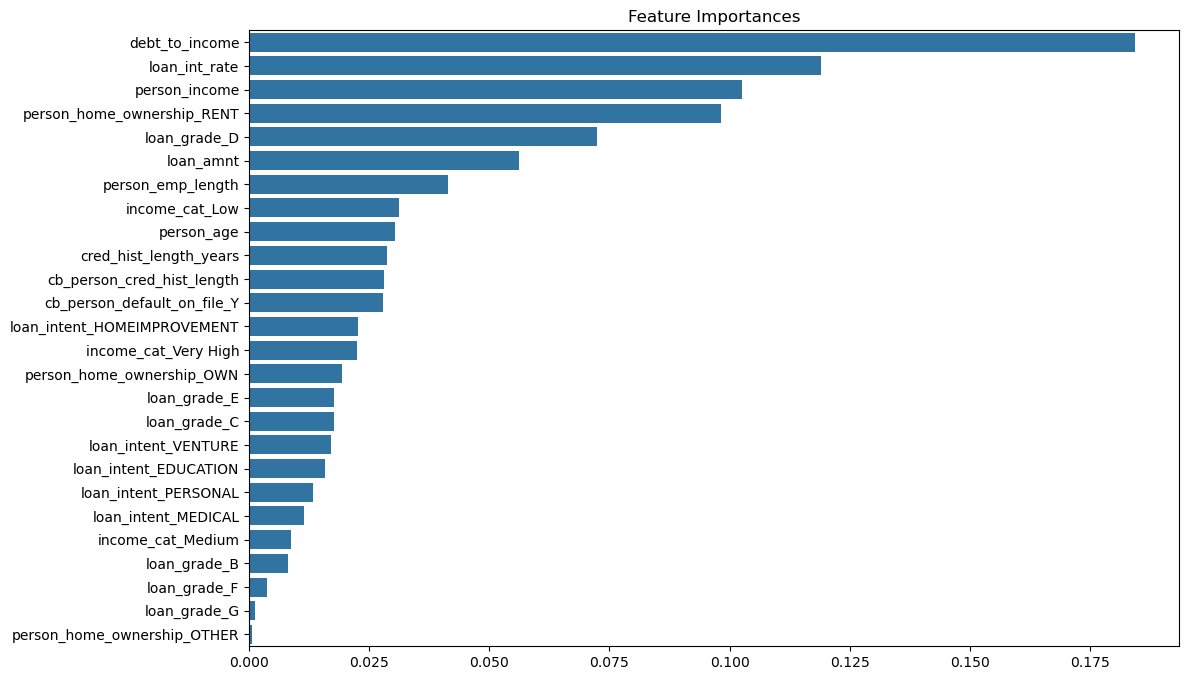


Top 10 Important Features:
debt_to_income: 0.1844
loan_int_rate: 0.1190
person_income: 0.1025
person_home_ownership_RENT: 0.0981
loan_grade_D: 0.0724
loan_amnt: 0.0561
person_emp_length: 0.0413
income_cat_Low: 0.0311
person_age: 0.0304
cred_hist_length_years: 0.0287


In [45]:
# Step 16: Feature Importances
onehot_feature_names = best_model.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(onehot_feature_names)

importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
plt.title("Feature Importances")
plt.show()

print("\nTop 10 Important Features:")
for i in range(min(10, len(feature_names))):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

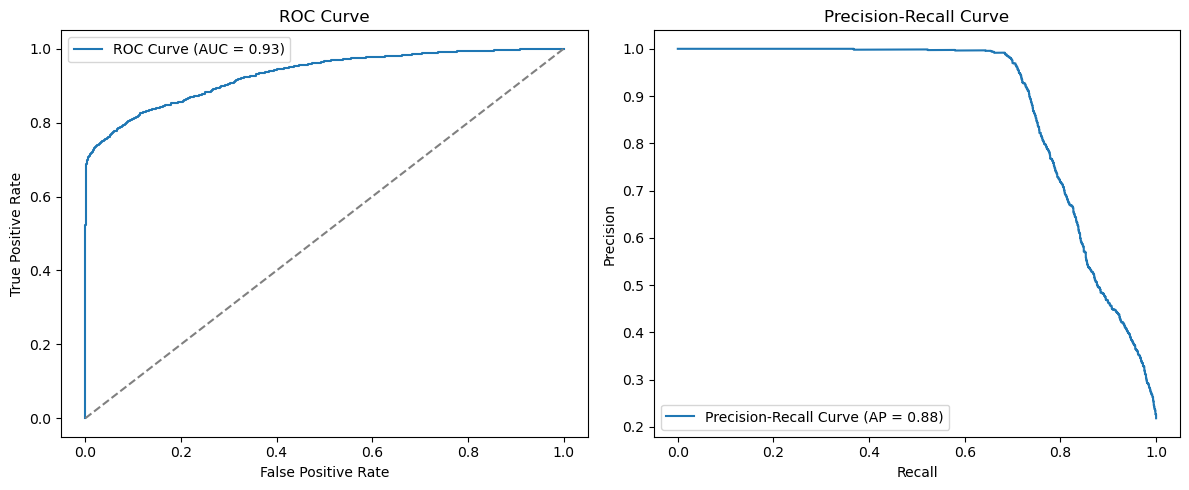

In [46]:
# Step 17: ROC & Precision-Recall Curves
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Precision-Recall Curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

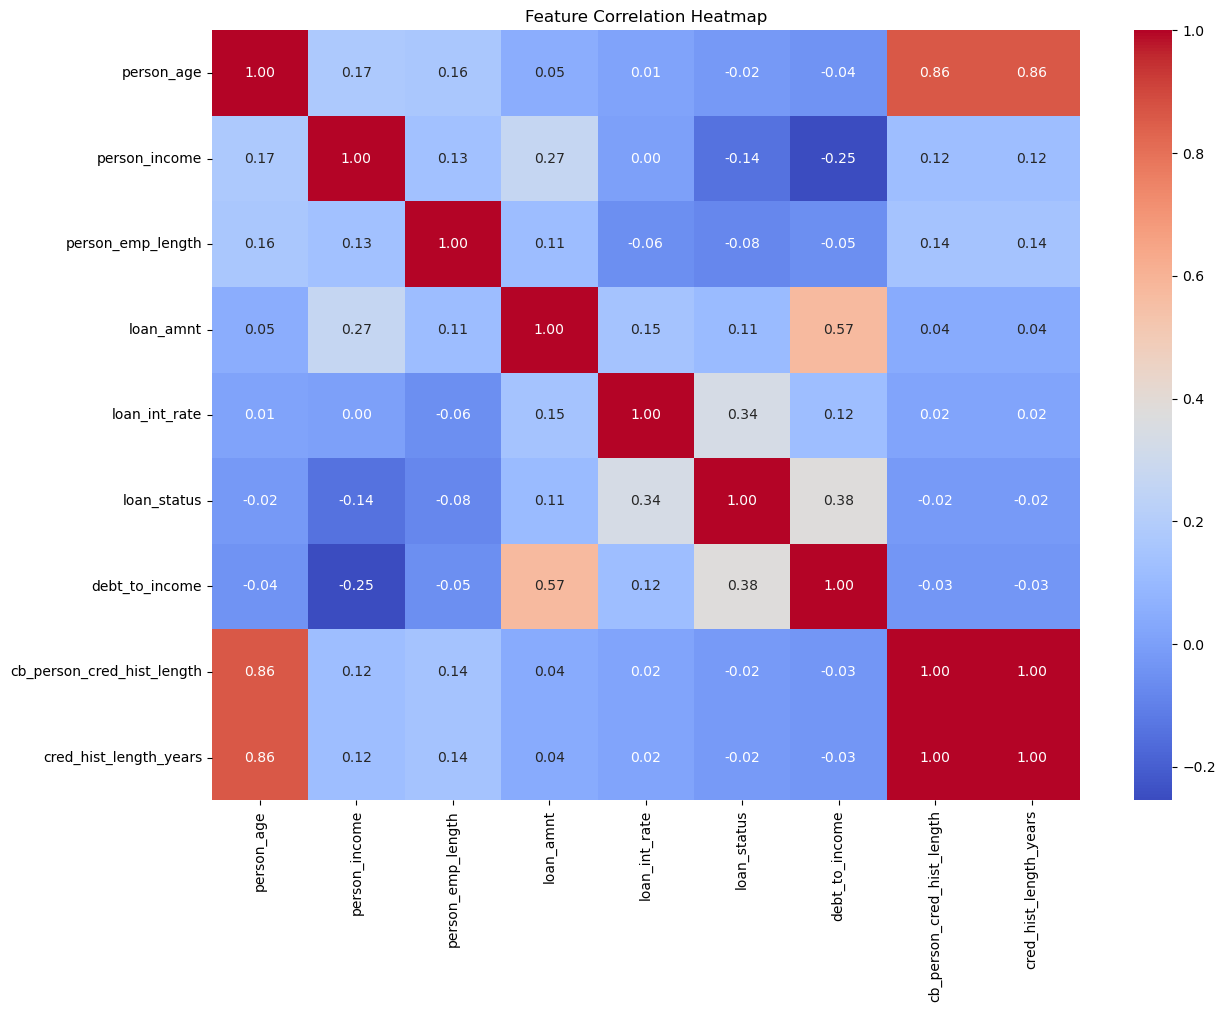

In [47]:
# Step 18: Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()




PermutationExplainer explainer: 101it [01:12,  1.18it/s]                                                               


<Figure size 640x480 with 0 Axes>

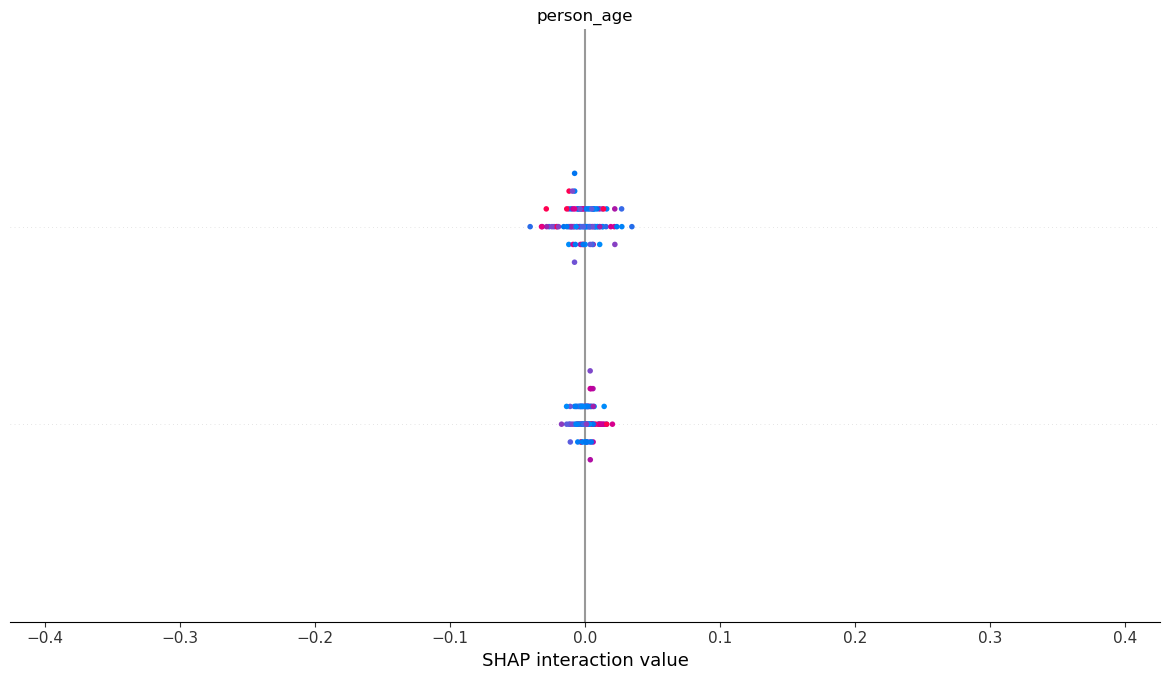

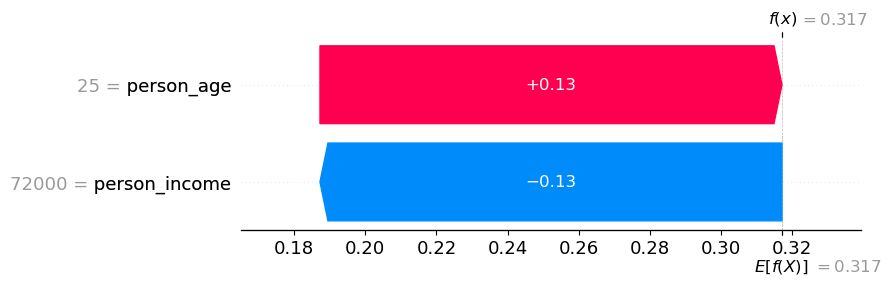

In [48]:
# Step 19: SHAP Explainability
import shap
from sklearn.preprocessing import LabelEncoder

# Sample data for explanation
X_sample = X_test.sample(100, random_state=42)

# Encode categorical columns if any
X_encoded = X_sample.copy()
for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Use a background dataset for masker (smaller sample)
background = X_encoded.sample(50, random_state=1)

# Create explainer with background data
explainer = shap.Explainer(best_model.predict_proba, background)

# Compute SHAP values on the full encoded sample
shap_values = explainer(X_encoded)

# Summary bar plot of feature importance
shap.summary_plot(shap_values, X_encoded, plot_type="bar", show=True)

# Prepare a single Explanation object for the waterfall plot for sample 0, class 1 (adjust if needed)
single_exp = shap.Explanation(
    values=shap_values.values[0, 1],            # SHAP values for sample 0, class 1
    base_values=shap_values.base_values[0, 1],  # base value for sample 0, class 1
    data=X_encoded.iloc[0].values,               # feature values for sample 0
    feature_names=X_encoded.columns.to_list()   # feature names
)

# Waterfall plot for the first sample for class 1
shap.plots.waterfall(single_exp, max_display=10)

In [49]:
# Step 20 - Stress Testing & Scenario Analysis
def simulate_stress_test(data, income_reduction=0.2, debt_increase=0.1):
    data_stress = data.copy()
    if 'person_income' in data_stress.columns:
        data_stress['person_income'] *= (1 - income_reduction)
    if 'person_debt' in data_stress.columns:
        data_stress['person_debt'] *= (1 + debt_increase)
    return data_stress

X_stress = simulate_stress_test(X_test, income_reduction=0.3, debt_increase=0.2)
stress_pred = best_model.predict(X_stress)
stress_risk = sum(stress_pred) / len(stress_pred)
print(f"\nStress Test Default Rate (30% income ↓, 20% debt ↑): {stress_risk:.2%}")


Stress Test Default Rate (30% income ↓, 20% debt ↑): 21.24%


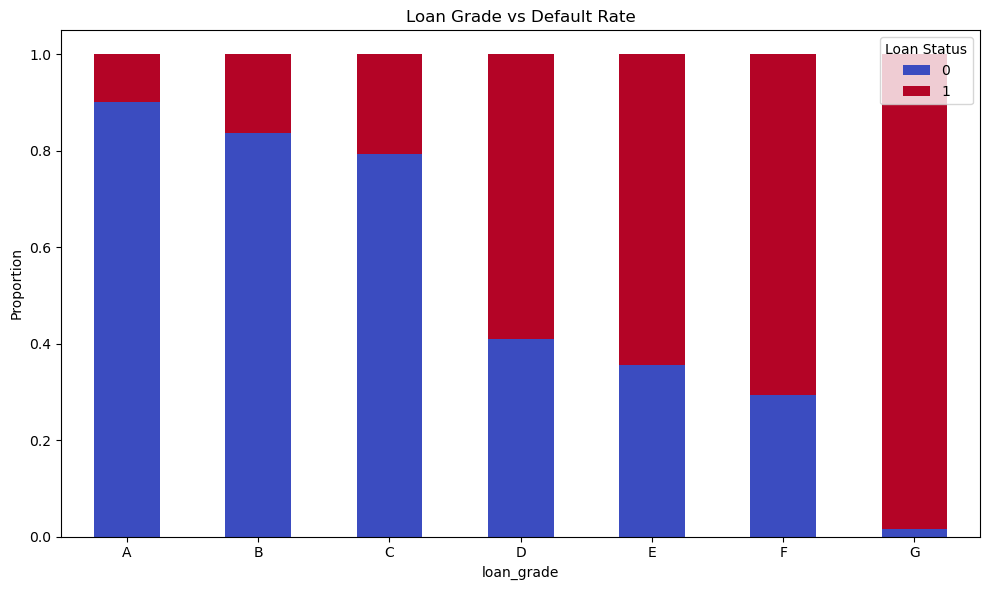

In [50]:
# Step 21 - Loan Grade vs Default Rate
if 'loan_grade' in df.columns:
    loan_grade_stats = df.groupby('loan_grade')[target_col].value_counts(normalize=True).unstack().fillna(0)
    loan_grade_stats.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
    plt.title("Loan Grade vs Default Rate")
    plt.ylabel("Proportion")
    plt.xticks(rotation=0)
    plt.legend(title='Loan Status')
    plt.tight_layout()
    plt.show()

In [51]:
# Step 22: Save pipeline and metadata
joblib.dump(best_model, 'credit_risk_pipeline.pkl')

model_metadata = {
    'model_version': '1.0.0',
    'train_date': '2025-05-25',
    'features': feature_names,
    'params': best_model.named_steps['classifier'].get_params()
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f)

In [52]:
# Step 23: Summary
print("\nSummary:")
print("- Missing values handled by SimpleImputer in pipeline.")
print("- Categorical variables one-hot encoded.")
print("- SMOTE integrated into pipeline for imbalance.")
print("- Random Forest hyperparameters tuned with GridSearchCV.")
print("- Model evaluated using ROC-AUC, PR-AUC, confusion matrix, classification report.")
print("- Threshold optimized for F1 score to balance precision and recall.")
print("- Economic cost of misclassification estimated.")
print("- SHAP explainability applied on pipeline.")
print("- Stress testing and scenario analysis simulated income/debt shocks.")
print("- Loan grade-wise default risk analysis visualized.")
print("- Model pipeline and metadata saved for deployment and governance.")

print(f"\nModel Evaluation Summary:")
print(f"- ROC-AUC: {roc_auc:.4f}")
print(f"- Average Precision: {avg_precision:.4f}")



Summary:
- Missing values handled by SimpleImputer in pipeline.
- Categorical variables one-hot encoded.
- SMOTE integrated into pipeline for imbalance.
- Random Forest hyperparameters tuned with GridSearchCV.
- Model evaluated using ROC-AUC, PR-AUC, confusion matrix, classification report.
- Threshold optimized for F1 score to balance precision and recall.
- Economic cost of misclassification estimated.
- SHAP explainability applied on pipeline.
- Stress testing and scenario analysis simulated income/debt shocks.
- Loan grade-wise default risk analysis visualized.
- Model pipeline and metadata saved for deployment and governance.

Model Evaluation Summary:
- ROC-AUC: 0.9299
- Average Precision: 0.8793


In [53]:
import os
import json
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import shap

# ✅ Use a folder with proper permissions (like Documents)
base_path = r'C:\Users\nikit\Downloads\Credit risk analysis'
output_folder = os.path.join(base_path, 'outputs')
os.makedirs(output_folder, exist_ok=True)

# ✅ Save the trained model pipeline
joblib.dump(best_model, os.path.join(output_folder, 'credit_risk_pipeline.pkl'))

# ✅ Save model metadata
model_metadata = {
    'model_version': '1.0.0',
    'train_date': '2025-05-25',
    'features': feature_names,
    'params': best_model.named_steps['classifier'].get_params()
}
with open(os.path.join(output_folder, 'model_metadata.json'), 'w') as f:
    json.dump(model_metadata, f, indent=4)

# ✅ Save SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_encoded, show=False)
plt.savefig(os.path.join(output_folder, 'shap_summary.png'), bbox_inches='tight')
plt.close()

# ✅ Save feature importance scorecard to Excel
scorecard_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
scorecard_df.to_excel(os.path.join(output_folder, 'scorecard.xlsx'), index=False)

# ✅ Confirmation message
print(f"Model, SHAP plot, and scorecard saved in: {output_folder}")


Model, SHAP plot, and scorecard saved in: C:\Users\nikit\Downloads\Credit risk analysis\outputs


<Figure size 640x480 with 0 Axes>